<a href="https://colab.research.google.com/github/yeshengw/robust-risk-aware-rl/blob/uploads/Example_2_Portfolio_Allocation_BM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import sys


drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
sys.path.append('/content/gdrive/My Drive')

Mounted at /content/gdrive


In [ ]:
from parameters import *
from market_models import *
from solution import *
from metrics import *
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda') 
else:
    device = torch.device('cpu') 
print(device)   

cuda


# Networks

In [ ]:
class InnerNet(nn.Module):
    
    def __init__(self, n_features, n_hidden, n_assets):
        super(InnerNet, self).__init__()

        self.fc_inp_h1 = nn.Linear(n_features, n_hidden)
        self.fc_h1_h2 = nn.Linear(n_hidden, n_hidden)
        self.fc_h2_h3 = nn.Linear(n_hidden, n_hidden)
        self.fc_h3_h4 = nn.Linear(n_hidden, n_hidden)
        self.fc_h4_out = nn.Linear(n_hidden, n_assets)
        self.myReLU = nn.ReLU()

    def forward(self, x):
        x = self.myReLU(self.fc_inp_h1(x))
        x = self.myReLU(self.fc_h1_h2(x))
        x = self.myReLU(self.fc_h2_h3(x))
        x = self.myReLU(self.fc_h3_h4(x))
        y = self.fc_h4_out(x)      
      
        return y

# Agents

In [ ]:
class SIR_CEV_Agent(Agent):
  def __init__(self, market_model, sim_params, train_params, device, outer_net = None, net_name = None, requires_update = False):
    Agent.__init__(self, market_model, sim_params, train_params, device, outer_net, net_name, requires_update)

  def sim_phi(self):
    # phi is simulated within market model
    return torch.FloatTensor(self.market_model.X[-1, :]).to(self.device)
   
  def PlotCustom(self, X, Y, adversary):
    adversary.PrintMetrics()
    adversary.PlotHistory()
    adversary.PlotDistortion(X, Y)

In [ ]:
class SIR_CEV_Adversary(Adversary):
  def __init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective = "minimize", reset_lm = False, reset_net = False):
    Adversary.__init__(self, rm_params, lm_params, wass_params, train_params, device, inner_net, net_name, objective, reset_lm, reset_net)

  def sim_theta(self, X_phi_T, market_model):
    # X_phi paths are generated jointly with stock prices in market model
    X_phi, t, S, r = market_model.X, market_model.t, market_model.S, market_model.r
    # get simulation parameters
    X0, Ndt, Nsims = X_phi[0, 0], X_phi.shape[0] - 1, X_phi.shape[1]

    # state consists of 5 feature
    state = np.zeros((Ndt+1, Nsims, 5))
    # first feature dimension is time 
    state[:, :, 0] = t.reshape(-1, 1)/t[-1]
    # second feature dimension is scaled asset prices
    state[:, :, 1: -1] = (S - S[0, 0, :].reshape(1, 1, -1)) / S[0, 0, :].reshape(1, 1, -1) * 10
    # third feature dimension is scaled benchmark
    state[:, :, -1] = X_phi/X0
    state_tensor = torch.FloatTensor(state).to(self.device)
    
    # inner_net outputs portfolio weights
    self.wt = self.inner_net(state_tensor)
    
    # propogate weights forward to find terminal portfolio value
    S_t = torch.FloatTensor(S).to(self.device)
    r_t = torch.FloatTensor(r).to(self.device)
    S_ret = (S_t[1:, :, :]-S_t[:-1, :, :])/S_t[:-1, :, :]
    dt = t[1] - t[0]
    # $R_t = (1 - \sum_{1}^{d-1} w_t) rf_t + \sum_{1}^{d-1} w_t * r_t$
    X_theta_ret = (1 - torch.sum(self.wt[:-1, :, :], axis=2)) * r_t[:-1, :] * dt+ torch.sum(self.wt[:-1, :, :] * S_ret , axis=2) 
    X_theta = torch.zeros((Ndt+1,Nsims)).to(self.device)    
    X_theta[0, :] = X0
    #$X_T = X_0 \prod_{t=1}^{t=T} (1 + R_t)$
    X_theta[1:, :] = X0 * torch.cumprod((1.0 + X_theta_ret), axis = 0)
    X_theta_T = X_theta[-1, :]
    
    return X_theta_T

  def PlotCustom(self, X, Y):
    self.PrintMetrics()
    self.PlotHistory()
    self.PlotDistortion(X, Y)

# Parameters

In [ ]:
sim_param_dict = { "S0" : np.array([1, 2]),
               "X0" : 1,
               "phi": np.array([0.2, 0.6, 0.1]),
               "Ndt" : 252 * 5,
               "Nassets": 3,
               "Nsims" : 5000,
               "T" : 5
             }
SIR_CEV_param_dict = { "P" : { "mu" : np.array([0.05,0.06]),
                          "sigma" : np.array([0.2,0.32]),
                          "beta" : np.array([-0.2, -0.3]),
                          "rho" : np.array([[1, 0.25, 0.2],[0.25, 1, 0.3], [0.2, 0.3, 1]]),
                          "r0" : 0.02,
                          "kappa" : 1,
                          "theta_r" : 0.02,
                          "sigma_r" : 0.02},
                  "Q" : { "kappa" : 1,
                          "theta_r" : 0.025,
                          "sigma_r" : 0.02}
                 }

LM_param_dict = { "lam": 10,
                  "mu": 100,
                  "mu_update": 1,
                  "update_freq": 1000
                  }

RM_param_dict = { "alpha" : 0.1,
                  "beta" : 0.9,
                  "p" : 0.75,
                  "rm_type" : 'alpha-beta'
                  }

# wass order is p in paper, wass_limit is epsilon
wass_param_dict = {"wass_order" : 2,
                   "wass_limit" : 0.1
                  }


train_param_dict = {"inner_epochs" : 3000,
                    "outer_epochs" : 3,
                    "plot_freq_inner": np.inf,
                    "plot_freq_outer" : 1,
                    "inner_lr" : 1e-3,
                    "freeze_market_iter" : 1,
                    "freeze_inner_iter" : 1
                   }

sim_params = Sim_Params(sim_param_dict)
market_params = MarketModel_Params(SIR_CEV_param_dict, Type = "SIR_CEV")
lm_params = LM_Params(LM_param_dict)
rm_params = RM_Params(RM_param_dict)
wass_params = Wass_Params(wass_param_dict)
train_params = Train_Params(train_param_dict)

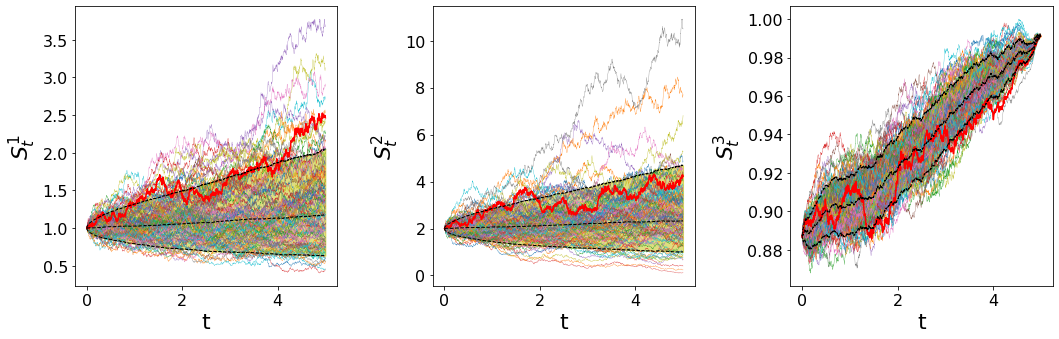

In [ ]:
SIR_CEV_model = SIR_CEV(market_params)
inner_net = InnerNet(5, 30, 3).to(device)
inner_name = root_dir + "SIR_CEV"
SIR_CEV_model.Sim(sim_params)
SIR_CEV_model.PlotSim()


# Results

Outer Epoch: 0 Outer Iter: 0
Wass Dist History:  [0.1024101972579956, 0.10181824117898941, 0.10239431262016296, 0.10182878375053406, 0.10237463563680649]
Risk Measure X_theta History:  [-1.2379318475723267, -1.2366976737976074, -1.2379019260406494, -1.2367230653762817, -1.2378637790679932]
Loss History:  [0.01909421756863594, -0.03567183017730713, 0.017913086339831352, -0.034443531185388565, 0.01636214181780815]
Augmented Lagrangian lambda: 10.452203750610352 mu: 100


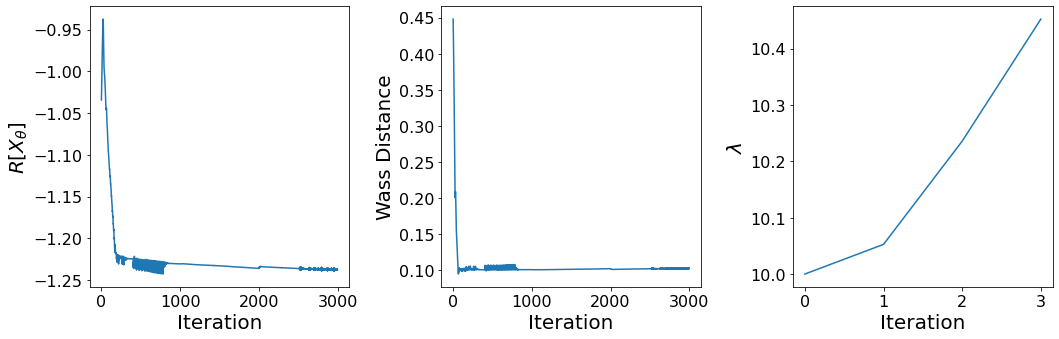

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


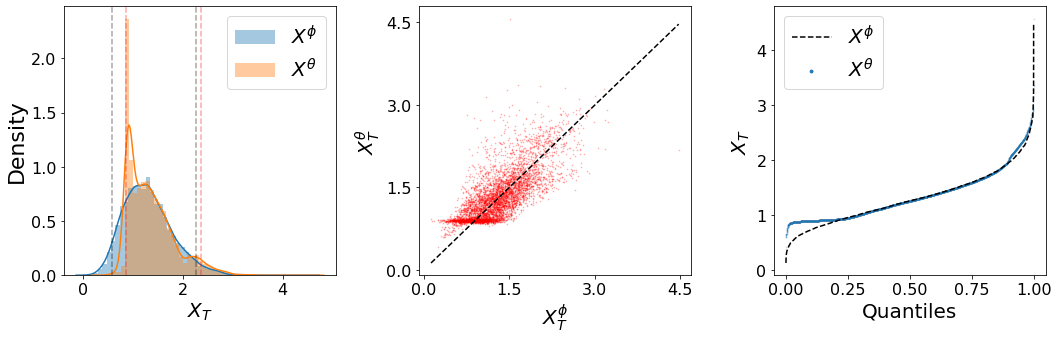

Outer Epoch: 1 Outer Iter: 0
Wass Dist History:  [0.10528130829334259, 0.10568875074386597, 0.10286776721477509, 0.1005718782544136, 0.09993190318346024]
Risk Measure X_theta History:  [-1.2441966533660889, -1.244469404220581, -1.2397592067718506, -1.234313726425171, -1.232284426689148]
Loss History:  [0.17356657981872559, 0.2587425708770752, 0.10062505304813385, -0.09589537978172302, -1.2496764659881592]
Augmented Lagrangian lambda: 10.892083942890167 mu: 100


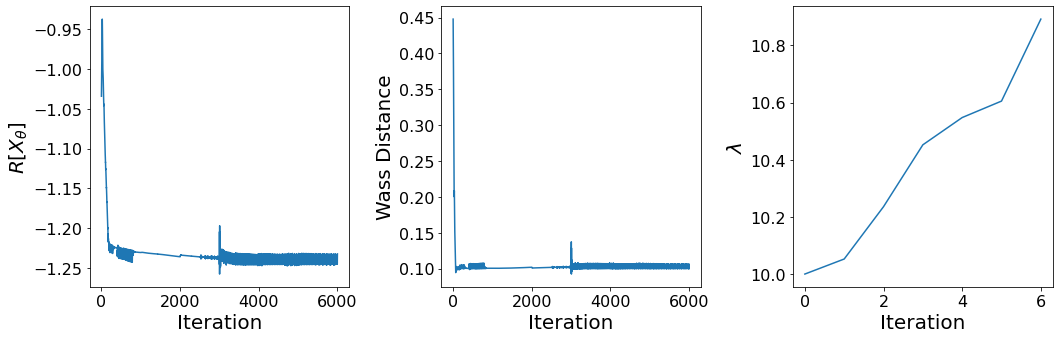

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


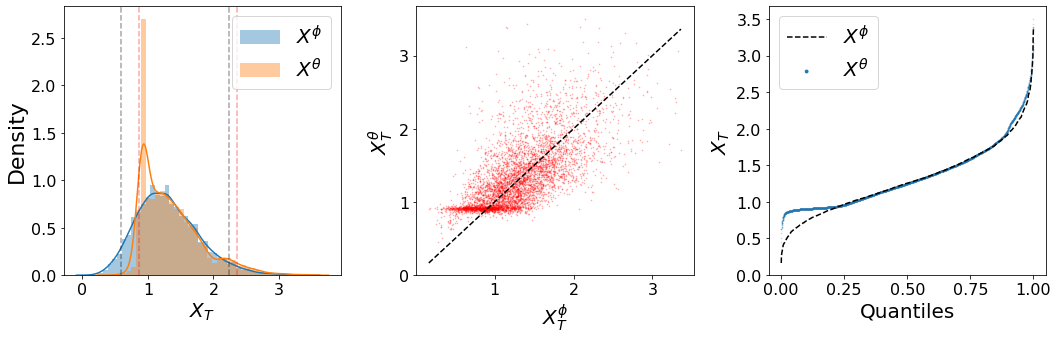

Outer Epoch: 2 Outer Iter: 0
Wass Dist History:  [0.10121596604585648, 0.09982608258724213, 0.1019720807671547, 0.10288779437541962, 0.10216937959194183]
Risk Measure X_theta History:  [-1.217182993888855, -1.214295506477356, -1.2185763120651245, -1.2203154563903809, -1.2191872596740723]
Loss History:  [0.18177272379398346, -1.2334952354431152, 0.22619560360908508, 0.2412436455488205, 0.11291994154453278]
Augmented Lagrangian lambda: 11.400982737541199 mu: 100


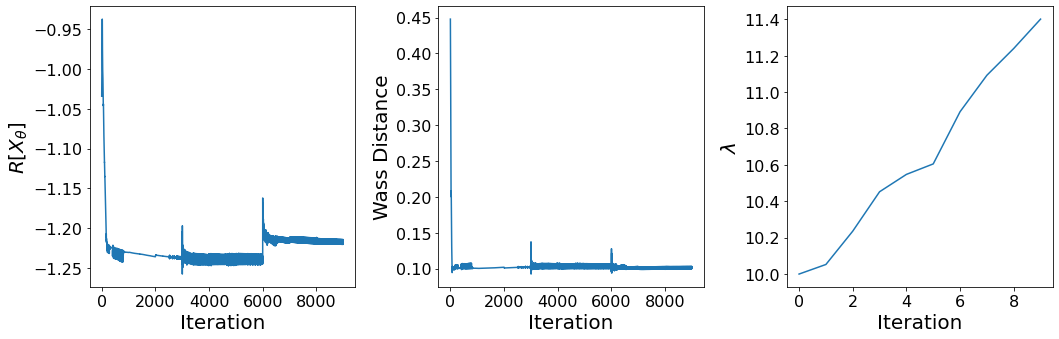

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


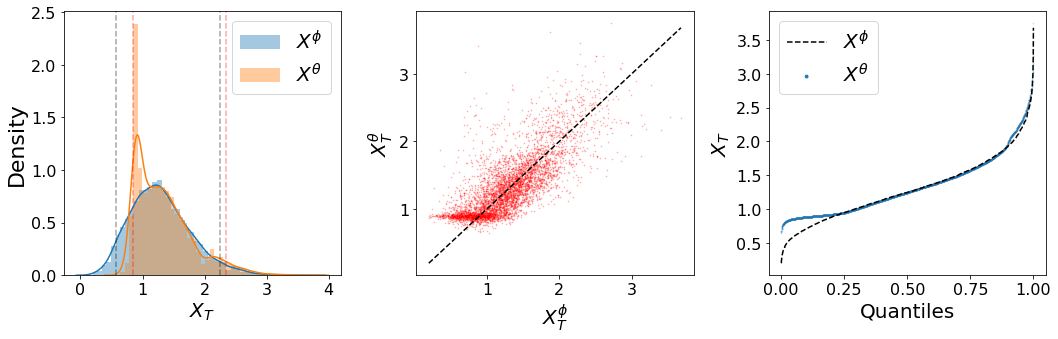

In [ ]:
agent = SIR_CEV_Agent(SIR_CEV_model, sim_params,train_params, device)
adversary = SIR_CEV_Adversary(rm_params, lm_params, wass_params, train_params, device, inner_net, inner_name)
agent.train(adversary)